In [ ]:
!pip install ipywidgets transformers[torch] datasets ipywidgets torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [1]:
import requests
from PIL import Image
import torch
from transformers import BlipProcessor, BlipForQuestionAnswering, BlipImageProcessor, AutoProcessor
from transformers import BlipConfig
from datasets import load_dataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Finetune BLIP1(base) - VQARAD - 100 epochs 

In [2]:
from datasets import load_dataset
dataset = load_dataset("flaviagiammarino/vqa-rad")

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

Question: are the lungs normal appearing?
Answer: no


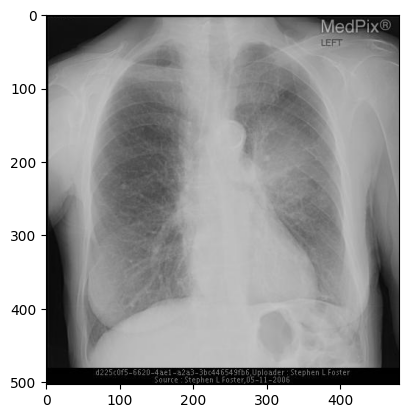

In [4]:
sample = dataset['train'][1]
PIL_image = Image.fromarray(np.array(sample['image'])).convert('RGB')
plt.imshow(sample['image'].convert('RGB'))
print("Question: {}".format(sample['question']))
print("Answer: {}".format(sample['answer']))

In [6]:
config = BlipConfig.from_pretrained("Salesforce/blip-vqa-base")

In [8]:
class VQADataset(torch.utils.data.Dataset):
    def __init__(self, data, segment, text_processor, image_processor):
        self.data = data
        self.questions = data['question']
        self.answers = data['answer']
        self.text_processor = text_processor
        self.image_processor = image_processor
        self.max_length = 32
        self.image_height = 128
        self.image_width = 128

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # get image + text
        answers = self.answers[idx]
        questions = self.questions[idx]
        image = self.data[idx]['image'].convert('RGB')
        text = self.questions[idx]

        image_encoding = self.image_processor(image,
                                  do_resize=True,
                                  size=(self.image_height,self.image_width),
                                  return_tensors="pt")

        encoding = self.text_processor(
                                  None,
                                  text,
                                  padding="max_length",
                                  truncation=True,
                                  max_length = self.max_length,
                                  return_tensors="pt"
                                  )
        # # remove batch dimension
        for k,v in encoding.items():
            encoding[k] = v.squeeze()
        encoding["pixel_values"] = image_encoding["pixel_values"][0]
        # # add labels
        labels = self.text_processor.tokenizer.encode(
            answers,
            max_length= self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors='pt'
        )[0]
        encoding["labels"] = labels

        return encoding

In [10]:
text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [11]:
train_data = dataset['train']
val_data = dataset['test']

train_vqa_dataset = VQADataset(data=train_data,
                     segment='train',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

val_vqa_dataset = VQADataset(data=val_data,
                     segment='test',
                     text_processor = text_processor,
                     image_processor = image_processor
                         )

In [12]:
train_vqa_dataset[0]

{'input_ids': tensor([  101,  2024,  4655,  1997,  1996,  4167,  1999, 14971, 10985,  1029,
          102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]), 'pixel_values': tensor([[[-1.6463, -1.6317, -1.6171,  ..., -1.7193, -1.6463, -1.5733],
         [-1.6317, -1.6025, -1.5879,  ..., -1.6171, -1.5879, -1.5733],
         [-1.6025, -1.6025, -1.5879,  ..., -1.3251, -1.5733, -1.5295],
         ...,
         [-1.7339, -1.7339, -1.7193,  ..., -1.5003, -1.0477, -0.8580],
         [-1.7777, -1.7923, -1.5149,  ..., -1.4127, -1.7923, -1.7923],
         [-1.7777, -1.7777, -1.5733,  ..., -1.5733, -1.7777, -1.7777]],

        [[-1.6020, -1.5870, -1.5720,  ..., -1.6771, -1.6020, -1.5270],
         [-1.5870, -1.5570, -1.5420,  ..., -1.5720, -1.5420, -1.527

In [13]:
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch

train_dataloader = DataLoader(train_vqa_dataset,
                              collate_fn=collate_fn,
                              batch_size=64,
                              shuffle=False)
val_dataloader = DataLoader(val_vqa_dataset,
                            collate_fn=collate_fn,
                            batch_size=64,
                            shuffle=False)

In [14]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
    print(k, v.shape)

input_ids torch.Size([64, 32])
attention_mask torch.Size([64, 32])
pixel_values torch.Size([64, 3, 128, 128])
labels torch.Size([64, 32])


In [15]:
from PIL import Image
import requests
from transformers import AutoProcessor, BlipForQuestionAnswering

In [16]:
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
model.cuda()
processor = AutoProcessor.from_pretrained("Salesforce/blip-vqa-base")

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

In [17]:
image_mean = image_processor.image_mean
image_std = image_processor.image_std

Question:  [CLS] are the lungs normal appearing? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Answer:  [CLS] no [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


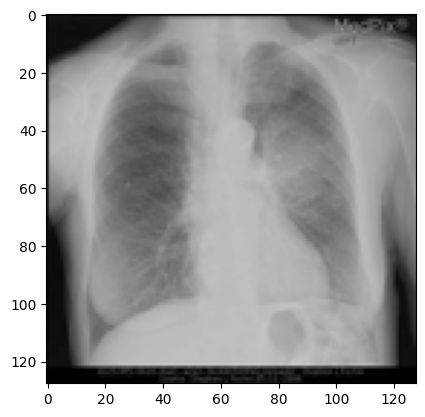

In [18]:
batch_idx = 1

unnormalized_image = (batch["pixel_values"][batch_idx].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)

print("Question: ",text_processor.decode(batch["input_ids"][batch_idx]))
print("Answer: ",text_processor.decode(batch["labels"][batch_idx]))
plt.imshow(Image.fromarray(unnormalized_image))

In [19]:
model.train()
for epoch in range(100):
    print(f"Epoch: {epoch}")
    total_loss = []
    for batch in tqdm(train_dataloader):
        # get the inputs;
        batch = {k:v.to(device) for k,v in batch.items()}

        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch)
        loss = outputs.loss
        total_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    print("Loss:", sum(total_loss))

Epoch: 0


  0%|          | 0/29 [00:00<?, ?it/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Loss: 224.0706934928894
Epoch: 1


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 128.315416097641
Epoch: 2


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 43.21507525444031
Epoch: 3


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 10.822859220206738
Epoch: 4


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 6.5510310381650925
Epoch: 5


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 4.918972693383694
Epoch: 6


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.9306618105620146
Epoch: 7


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 3.3527504596859217
Epoch: 8


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.868644453585148
Epoch: 9


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.422966280952096
Epoch: 10


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 2.061135140247643
Epoch: 11


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.7794954925775528
Epoch: 12


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.5533697325736284
Epoch: 13


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.3733316315338016
Epoch: 14


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.2345284027978778
Epoch: 15


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 1.1027011396363378
Epoch: 16


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.9679703861474991
Epoch: 17


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.8850351739674807
Epoch: 18


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.8066361211240292
Epoch: 19


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.7126044984906912
Epoch: 20


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.6275115199387074
Epoch: 21


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.589521424844861
Epoch: 22


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.5091962516307831
Epoch: 23


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.45698082447052
Epoch: 24


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.41765893111005425
Epoch: 25


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.37011008290573955
Epoch: 26


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.355922959279269
Epoch: 27


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.3331083196680993
Epoch: 28


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.30071870400570333
Epoch: 29


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.2802556143142283
Epoch: 30


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.2636199912521988
Epoch: 31


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.21255264175124466
Epoch: 32


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.18708054209128022
Epoch: 33


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.15909752529114485
Epoch: 34


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.1421206892700866
Epoch: 35


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.1293925850186497
Epoch: 36


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.11750373709946871
Epoch: 37


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.10793849744368345
Epoch: 38


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.09908235224429518
Epoch: 39


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.09179992903955281
Epoch: 40


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.08497366029769182
Epoch: 41


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.07936737046111375
Epoch: 42


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.07404017867520452
Epoch: 43


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.06962663296144456
Epoch: 44


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.06539622228592634
Epoch: 45


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.061874446691945195
Epoch: 46


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.05843964533414692
Epoch: 47


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.055567626492120326
Epoch: 48


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.05272170016542077
Epoch: 49


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.05034833203535527
Epoch: 50


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04793191276257858
Epoch: 51


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04593681910773739
Epoch: 52


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04386254900600761
Epoch: 53


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.0421894557075575
Epoch: 54


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.04035332874627784
Epoch: 55


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03891991067212075
Epoch: 56


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.037296191207133234
Epoch: 57


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.036081811354961246
Epoch: 58


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03458688408136368
Epoch: 59


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.033523286518175155
Epoch: 60


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.032206498086452484
Epoch: 61


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.03122580557828769
Epoch: 62


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.030013233073987067
Epoch: 63


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.029158043849747628
Epoch: 64


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02808285760693252
Epoch: 65


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02729015762452036
Epoch: 66


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.026300629193428904
Epoch: 67


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.025593167869374156
Epoch: 68


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02470635250210762
Epoch: 69


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02396692510228604
Epoch: 70


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.023120464524254203
Epoch: 71


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02236915653338656
Epoch: 72


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.02168617569259368
Epoch: 73


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.020907761092530563
Epoch: 74


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.020171984244370833
Epoch: 75


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.019299995416076854
Epoch: 76


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01860194921027869
Epoch: 77


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.017849612806458026
Epoch: 78


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.017187519930303097
Epoch: 79


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01655947437393479
Epoch: 80


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.0160720240091905
Epoch: 81


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.015635414223652333
Epoch: 82


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.015213658276479691
Epoch: 83


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.0148049162235111
Epoch: 84


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.014416144142160192
Epoch: 85


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.014041834860108793
Epoch: 86


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01367879071040079
Epoch: 87


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.013335623691091314
Epoch: 88


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01300655453815125
Epoch: 89


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.012687842594459653
Epoch: 90


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.012374662765068933
Epoch: 91


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.012077859486453235
Epoch: 92


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011788574716774747
Epoch: 93


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.011500565247843042
Epoch: 94


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01122776439297013
Epoch: 95


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.01096219287137501
Epoch: 96


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010704298794735223
Epoch: 97


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010457138472702354
Epoch: 98


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.010220914002275094
Epoch: 99


  0%|          | 0/29 [00:00<?, ?it/s]

Loss: 0.00999095439328812


In [20]:
# Assuming 'model' is your fine-tuned model and 'processor' is your tokenizer/processor
save_directory = "D:/MedVQA/blip1(base)-vqarad-adamW-100epochs"

# Save the fine-tuned model and processor locally
model.save_pretrained(save_directory)
#text_processor.save_pretrained(save_directory)
#image_processor.save_pretrained(save_directory)
processor.save_pretrained(save_directory)
print(f"Fine-tuned model and processor saved to {save_directory}")

Fine-tuned model and processor saved to D:/MedVQA/blip1(base)-vqarad-adamW-100epochs


In [21]:
model.eval()

BlipForQuestionAnswering(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-05, e

In [22]:
def evaluate_model(model, dataloader, processor, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in tqdm(dataloader):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            # Convert input_ids to tensor
            input_ids = torch.tensor(batch['input_ids']).to(device)
            
            # Generate predictions
            predictions = model.generate(
                pixel_values=batch['pixel_values'],
                input_ids=input_ids,  # Pass input_ids as tensor
                attention_mask=batch['attention_mask'],
                max_length=32
            )
            
            # Decode predictions and labels
            decoded_preds = processor.batch_decode(predictions, skip_special_tokens=True)
            decoded_labels = processor.batch_decode(batch['labels'], skip_special_tokens=True)
            
            # Calculate accuracy
            for pred, label in zip(decoded_preds, decoded_labels):
                if pred.strip().lower() == label.strip().lower():
                    total_correct += 1
                total_samples += 1
    
    avg_val_loss = total_loss / len(dataloader)
    val_accuracy = total_correct / total_samples
    return avg_val_loss, val_accuracy

# Evaluate the model
val_loss, val_accuracy = evaluate_model(model, val_dataloader, processor, device)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\LABICA\AppData\Local\Temp\ipykernel_19580\2816787981.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch['input_ids']).to(device)


Validation Loss: 0.4193005673587322
Validation Accuracy: 0.44567627494456763


Question:  are there ekg leads on this patient?
Predicted Answer:  yes
Actual Answer:  yes


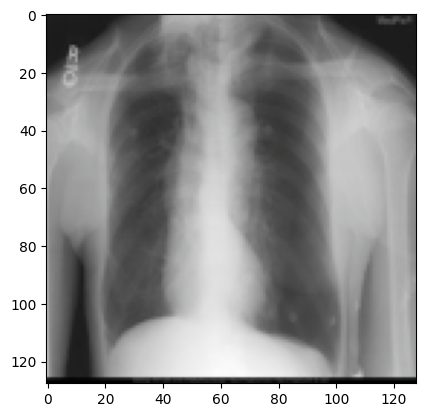

In [33]:
idx = 300
sample = val_vqa_dataset[idx]
print("Question: ",text_processor.decode(sample['input_ids'], skip_special_tokens=True))
sample = {k: v.unsqueeze(0).to(device) for k,v in sample.items()}

# forward pass
outputs = model.generate(pixel_values=sample['pixel_values'],
                        input_ids=sample['input_ids'])
print("Predicted Answer: ",text_processor.decode(outputs[0],skip_special_tokens=True))
print("Actual Answer: ",text_processor.decode(sample['labels'][0], skip_special_tokens=True))
#########################################################################
unnormalized_image = (sample["pixel_values"][0].cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
plt.imshow(Image.fromarray(unnormalized_image))